In [1]:
df=spark.sql("select * from user_erin.nbabetting1")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,None,pyspark,idle,Link,,erin,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------+-------+-------+-------+----+----------+-----+------+------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------+-------+
|      id|game_id|team_id|playoff| season|home|  realdate|month| 

In [3]:
from pyspark.ml.feature import VectorAssembler
df_assembler1 = VectorAssembler(inputCols=['fg','fga','fg_pct','fg3','fg3a','fg3_pct','ft','fta','ft_pct','orb','drb','trb','ast','stl','blk','tov','pf','number_of_ots','attendance','win','newfg','newfga','newfg_pct','newfg3','newfg3a','newfg3_pct','newft','newfta','newft_pct','neworb','newdrb','newtrb','newast','newstl','newblk','newtov','newpf','newnumber_of_ots','newattendance','newwin','home','eelo','enewelo'],outputCol='features')
today= df_assembler1.transform(df)
today=today.select("game_id","curwin","features","year","season")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
today.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- game_id: integer (nullable = true)
 |-- curwin: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- year: double (nullable = true)
 |-- season: string (nullable = true)

In [5]:
dftrain=today.filter(today['season']!="2019-20")
dftest=today.filter(today['season']== "2019-20")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
dftest.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

824

In [7]:
train=dftrain.filter(today['season']!='2018-19')
test=dftrain.filter(today['season']=='2018-19')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
train.show(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+--------------------+------+-------+
|game_id|curwin|            features|  year| season|
+-------+------+--------------------+------+-------+
|  51056|   1.0|[0.25674703911213...|2010.0|2009-10|
|  51418|   0.0|[-0.2464589158092...|2010.0|2009-10|
+-------+------+--------------------+------+-------+
only showing top 2 rows

In [9]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator  = MulticlassClassificationEvaluator(labelCol="curwin", predictionCol="prediction",metricName='accuracy')
lr = LogisticRegression(featuresCol="features",labelCol = 'curwin').fit(train)
lrpredictions= lr.transform(test)
lracc=evaluator.evaluate(lrpredictions)
print("lrresult",lracc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lrresult 0.6692073170731707

In [10]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol="features",labelCol = 'curwin')
dtmodel= dt.fit(train)
dtpredictions=dtmodel.transform(test)
dtroc=evaluator.evaluate(dtpredictions)
print("dtresult",dtroc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

dtresult 0.6440548780487805

In [11]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="curwin", featuresCol="features", numTrees=20)
rfmodel= rf.fit(train)
rfpredictions=rfmodel.transform(test)
rfroc=evaluator.evaluate(rfpredictions)
print("rfresult",rfroc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rfresult 0.6509146341463414

In [12]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="curwin", featuresCol="features", maxIter=10)
gbtmodel=gbt.fit(train)
gbtpredictions=gbtmodel.transform(test)
gbtroc=evaluator.evaluate(gbtpredictions)
print("gbtresult",gbtroc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

gbtresult 0.6402439024390244

In [13]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(labelCol="curwin", featuresCol="features", maxIter=10, regParam=0.1)
lsvcModel = lsvc.fit(train)
lsvcpredictions=lsvcModel.transform(test)
lsvcroc=evaluator.evaluate(lsvcpredictions)
print("lsvcresult",lsvcroc)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

lsvcresult 0.6067073170731707

**将分类模型的准确李结果可视化**

In [14]:
from matplotlib import pyplot as plt1
import numpy as np
result=[lracc,dtroc,rfroc,gbtroc,lsvcroc]
name = ["lr","dt","rf","gbt","lsvc"]
plt1.subplots_adjust(wspace =0.5, hspace =0)
x = np.arange(len(name))
width = 0.25
plt1.bar(x, result,  width=width, label='c',color='darkorange',tick_label=name)
plt1.ylim(0.55,0.85)

plt1.ylabel('accuracy')
plt1.xlabel('classifier models')
plt1.xticks()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

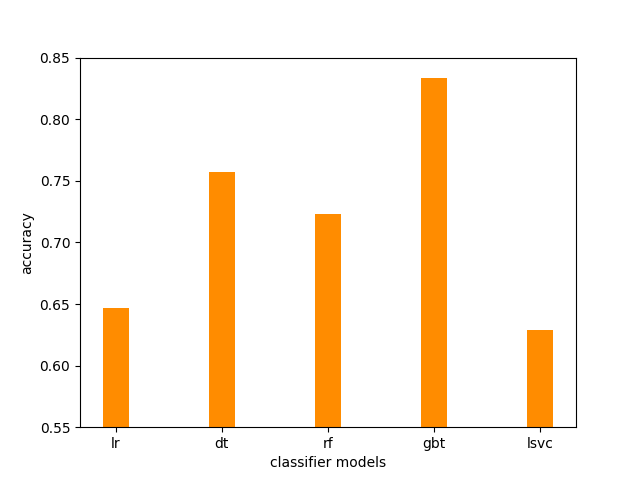

In [15]:
%matplot plt1

结果分析：
根据以上的准确度分析，选择表现较好的LogisticRegression模型，来进行后续的参数组合训练。

In [32]:
spark.stop()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…